In [1]:
require(tidyverse)
require(party)
require(mgcv)
require(lattice)
require(languageR)
require(repr)
require(itsadug)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: party

Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich


Attaching package: ‘strucchange’


The following object is masked from ‘package:stringr’:

    boundary


Loading required package: mgcv

Loading required package: nlme


Attaching pac

In [2]:
nwdata = read_csv("../data/sense_graph/sense_graph_nonword.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  Nonword_Trad = col_character(),
  Nonword_Sim = col_character(),
  C1 = col_character(),
  C2 = col_character(),
  word = col_character(),
  c1 = col_character(),
  c2 = col_character(),
  c1_node = col_character(),
  c2_node = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [3]:
nwdata$RTinv = -1000/nwdata$RT
nwdata$log_freq_c1 = log(nwdata$`Google-freq-C1`)
nwdata$log_freq_c2 = log(nwdata$`Google-freq-C2`)
nwdata$log_c1_sfreq = log(nwdata$c1_sense_freq)
nwdata$log_c2_sfreq = log(nwdata$c2_sense_freq)
colnames(nwdata)[colnames(nwdata)=='Stroke-1'] = "stroke_c1"
colnames(nwdata)[colnames(nwdata)=='Stroke-2'] = "stroke_c2"
nwdata$min_dist_weighted = with(nwdata, sqrt(log_c1_sfreq+log_c2_sfreq)*min_dist)

In [4]:
names(nwdata)

[1] "Nonword_Trad"      "Nonword_Sim"       "Ntrials"          
 [4] "Acc"               "RT"                "RT-SE"            
 [7] "RT-SD"             "zRT"               "C1"               
[10] "C2"                "Google-freq-C1"    "stroke_c1"        
[13] "Google-freq-C2"    "stroke_c2"         "word"             
[16] "c1"                "c2"                "c1_node"          
[19] "c2_node"           "c1_sense_freq"     "c2_sense_freq"    
[22] "min_dist"          "morph_dw"          "morph_udw"        
[25] "morph_ds"          "morph_uds"         "c1_nsense"        
[28] "c2_nsense"         "c1_wD"             "c2_wD"            
[31] "c1_rEV"            "c2_rEV"            "RTinv"            
[34] "log_freq_c1"       "log_freq_c2"       "log_c1_sfreq"     
[37] "log_c2_sfreq"      "min_dist_weighted"

In [43]:
nwdata$log_nsense_c12 = log(nwdata$c1_nsense+nwdata$c2_nsense)
nwdata$log_nsense_c1 = log(nwdata$c1_nsense)
nwdata$log_nsense_c2 = log(nwdata$c2_nsense)

In [5]:
## helper function to plot interaction
popt = function(w, h, r=200) { options(repr.plot.width=w, repr.plot.height=h, repr.plot.res=r) }
plot_int = function(model, idx, x, y, ...){
    popt(12, 6)
    par(mfrow=c(1,2))
    suppressWarnings(plot(model, select=idx, lwd=2, labcex=1, ...))
    vis.gam(model, view=c(x, y), plot.type="contour", color="topo", too.far=0.1, ...)
}

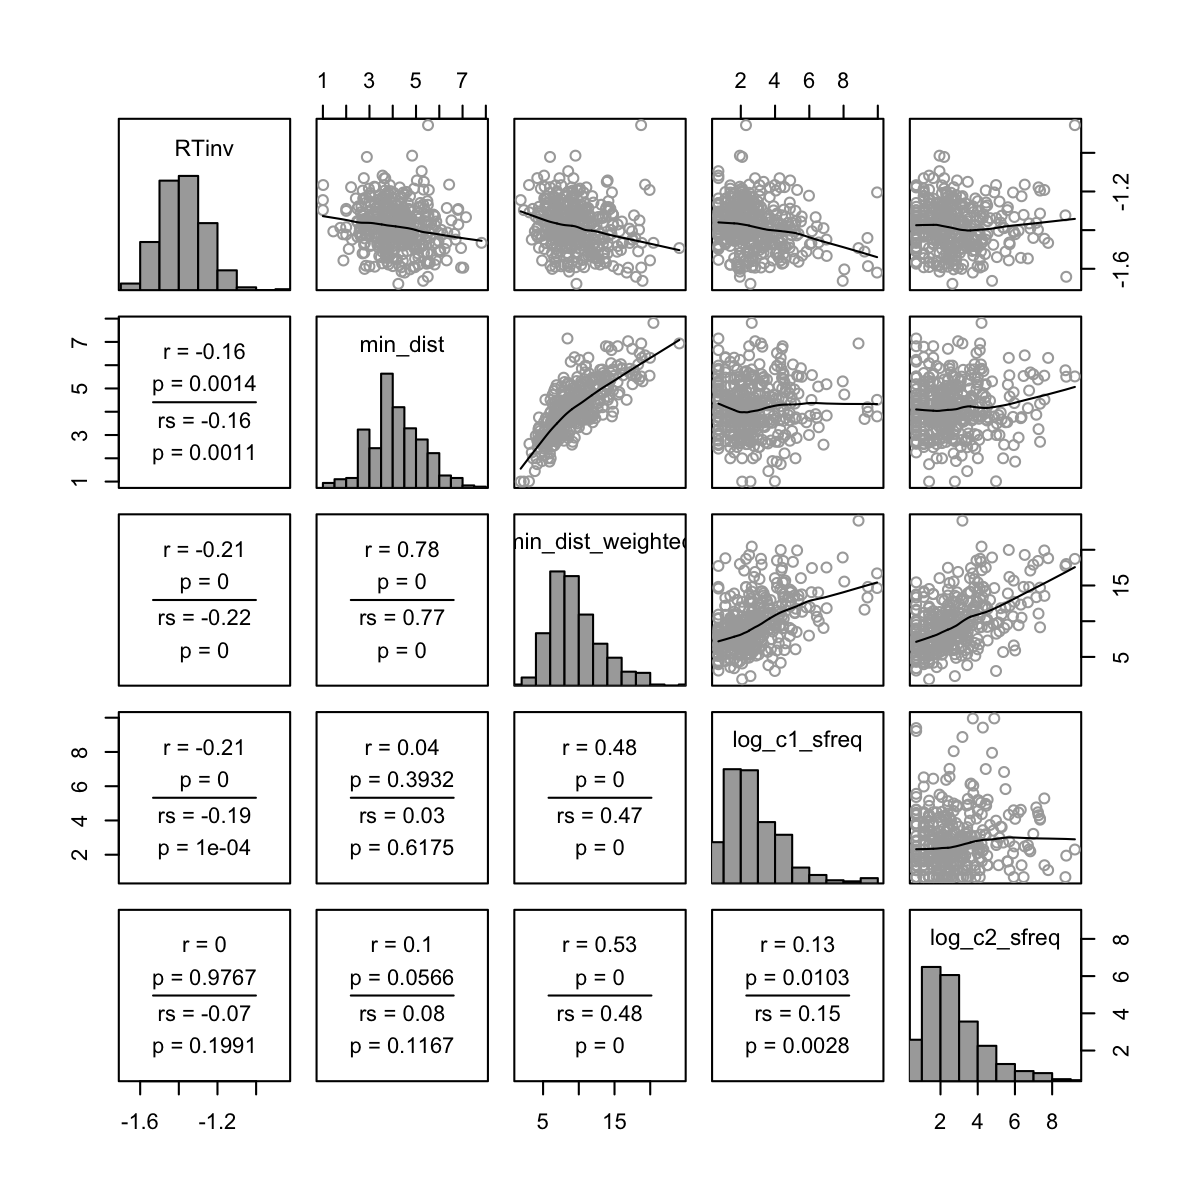

In [6]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res=200)
pairscor.fnc(nwdata[,c("RTinv", "min_dist", "min_dist_weighted", "log_c1_sfreq", "log_c2_sfreq")])

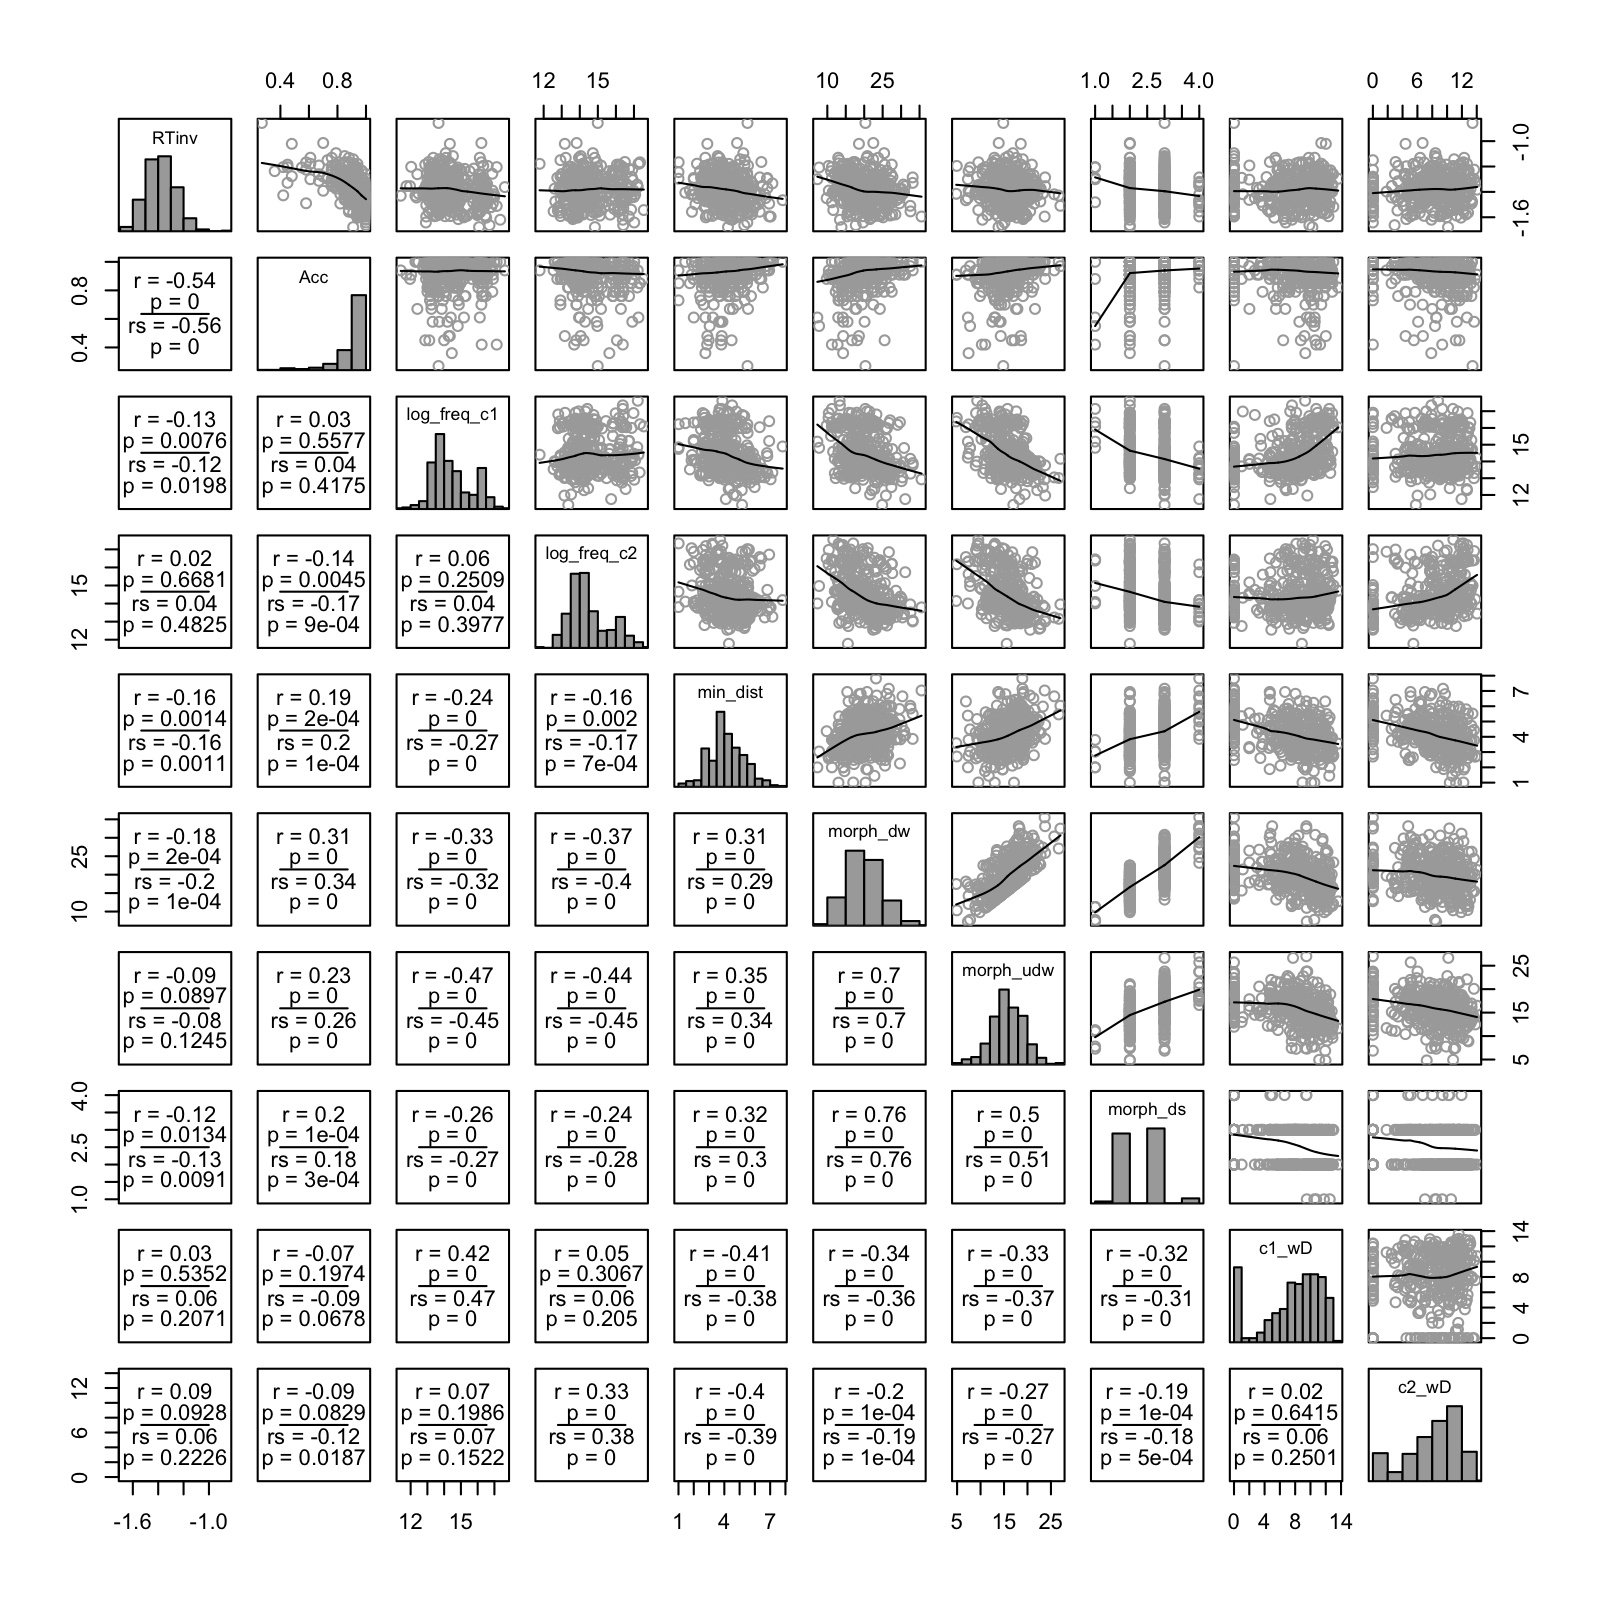

In [14]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res=200)
pairscor.fnc(nwdata[,c("RTinv", "Acc", "log_freq_c1", "log_freq_c2", "min_dist", "morph_dw", "morph_udw", "morph_ds", "c1_wD", "c2_wD")])

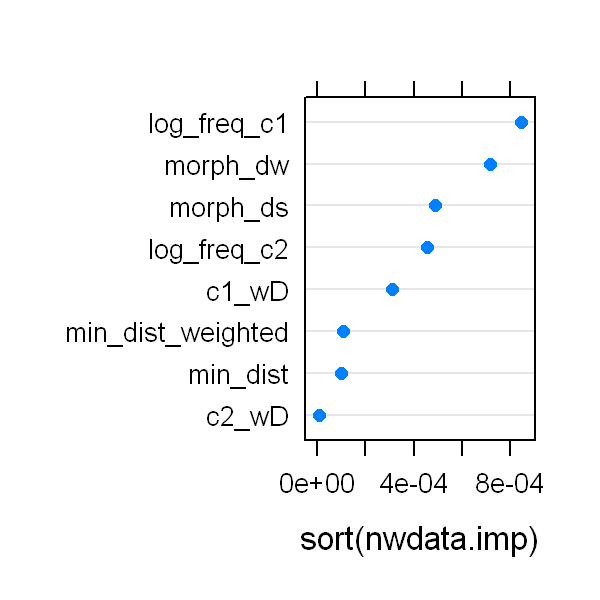

In [131]:
popt(3, 3, 200)
nwdata.cf = cforest(RTinv~., data=nwdata[,
                    c("RTinv", "log_freq_c1", "log_freq_c2", "min_dist", "min_dist_weighted", "morph_dw", "morph_ds", "c1_wD", "c2_wD")])
nwdata.imp = varimp(nwdata.cf)
dotplot(sort(nwdata.imp), main=list(cex=2))

## Model

In [58]:
m0 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2), data=nwdata)
summary(m0)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002262  -606.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df     F p-value   
s(log_freq_c1) 2.680  3.437 4.597 0.00234 **
s(log_freq_c2) 2.212  2.840 2.685 0.04749 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.00889   Deviance explained = 1.08%
fREML = -1883.6  Scale est. = 0.012753  n = 2493

In [132]:
m1 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+s(morph_dw), data=nwdata)
summary(m1)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002191  -626.2   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df      F p-value    
s(log_freq_c1) 1.064  1.126  58.02  <2e-16 ***
s(log_freq_c2) 1.000  1.000  54.49  <2e-16 ***
s(morph_dw)    1.000  1.000 174.31  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0697   Deviance explained = 7.08%
fREML = -1960.1  Scale est. = 0.01197   n = 2493

In [133]:
m2 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+s(min_dist)+s(morph_dw), data=nwdata)
summary(m2)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002189    -627   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
               edf Ref.df       F p-value    
s(log_freq_c1)   1      1  69.285 < 2e-16 ***
s(log_freq_c2)   1      1  57.465 < 2e-16 ***
s(min_dist)      1      1   7.274 0.00704 ** 
s(morph_dw)      1      1 156.999 < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.072   Deviance explained = 7.35%
fREML = -1958.5  Scale est. = 0.011941  n = 2493

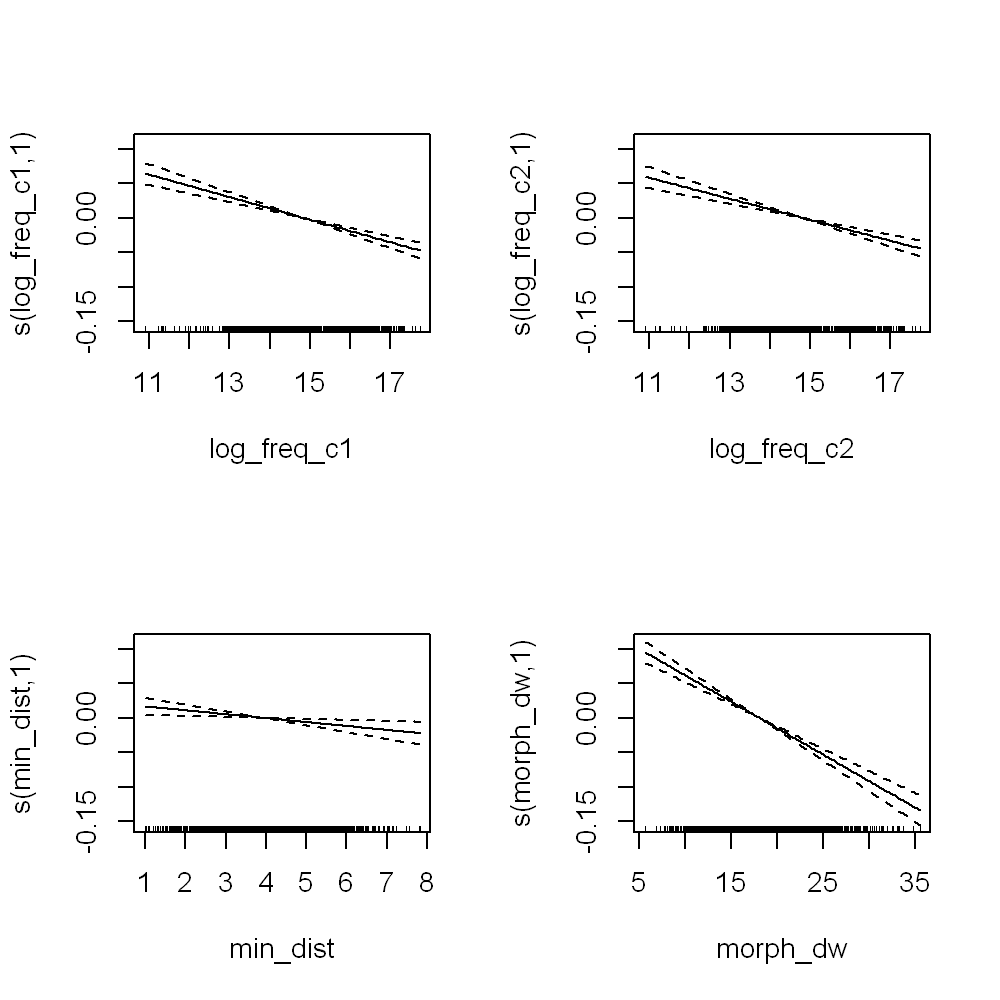

In [192]:
plot(m2, pages=1)

In [31]:
m3 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+s(min_dist)+s(morph_dw)+s(c1_wD), data=nwdata, method="ML")
summary(m3)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw) + 
    s(c1_wD)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.380301   0.005673  -243.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
               edf Ref.df      F  p-value    
s(log_freq_c1)   1      1 20.390 9.05e-06 ***
s(log_freq_c2)   1      1  2.347  0.12637    
s(min_dist)      1      1  8.837  0.00314 ** 
s(morph_dw)      1      1 19.051 1.66e-05 ***
s(c1_wD)         1      1  0.051  0.82217    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0915   Deviance explained = 10.3%
-ML = -303.58  Scale est. = 0.012585  n = 391

In [32]:
m4 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+s(morph_dw)+s(c1_wD), data=nwdata, method="ML")
summary(m4)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw) + s(c1_wD)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.380301   0.005731  -240.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
               edf Ref.df      F  p-value    
s(log_freq_c1)   1      1 18.808 1.88e-05 ***
s(log_freq_c2)   1      1  1.623    0.203    
s(morph_dw)      1      1 22.896 2.65e-06 ***
s(c1_wD)         1      1  0.570    0.451    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.073   Deviance explained = 8.25%
-ML = -299.14  Scale est. = 0.012841  n = 391

In [33]:
AIC(m3, m4)

,df,AIC
,<dbl>,<dbl>
m3,7.000140,-593.1517
m4,6.000101,-586.2785


In [34]:
compareML(m3, m4)

m3: RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw) + 
    s(c1_wD)

m4: RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw) + s(c1_wD)


Warning message in sprintf("*  ", h1):
“one argument not used by format '*  '”



Chi-square test of ML scores
-----
  Model     Score Edf Difference    Df p.value Sig.
1    m4 -299.1392   9                              
2    m3 -303.5758  11      4.437 2.000   0.012  *  

AIC difference: -6.87, model m3 has lower AIC.



Warning message in compareML(m3, m4):
“Only small difference in ML...
”


In [35]:
m5 = bam(RTinv~s(log_freq_c1)+s(min_dist)+s(morph_dw), data=nwdata, method="ML")
summary(m5)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(min_dist) + s(morph_dw)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.380301   0.005676  -243.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
               edf Ref.df     F  p-value    
s(log_freq_c1)   1      1 22.13 3.85e-06 ***
s(min_dist)      1      1  8.84  0.00313 ** 
s(morph_dw)      1      1 17.00 4.60e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0906   Deviance explained = 9.76%
-ML = -302.38  Scale est. = 0.012597  n = 391

In [36]:
compareML(m3, m5)

m3: RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw) + 
    s(c1_wD)

m5: RTinv ~ s(log_freq_c1) + s(min_dist) + s(morph_dw)


Warning message in sprintf("   ", h1):
“one argument not used by format '   '”



Chi-square test of ML scores
-----
  Model     Score Edf Difference    Df p.value Sig.
1    m5 -302.3832   7                              
2    m3 -303.5758  11      1.193 4.000   0.665     

AIC difference: 1.61, model m5 has lower AIC.



Warning message in compareML(m3, m5):
“Only small difference in ML...
”


In [37]:
m5.1 = bam(RTinv~s(log_freq_c1)+te(min_dist,morph_dw), data=nwdata, method="ML")
summary(m5.1)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + te(min_dist, morph_dw)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.380301   0.005674  -243.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                      edf Ref.df    F  p-value    
s(log_freq_c1)          1      1 21.4 5.50e-06 ***
te(min_dist,morph_dw)   3      3 11.8 5.83e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0913   Deviance explained = 10.1%
-ML = -303.04  Scale est. = 0.012587  n = 391

In [38]:
compareML(m5, m5.1)

m5: RTinv ~ s(log_freq_c1) + s(min_dist) + s(morph_dw)

m5.1: RTinv ~ s(log_freq_c1) + te(min_dist, morph_dw)


Warning message in sprintf("   ", h1):
“one argument not used by format '   '”



Chi-square test of ML scores
-----
  Model     Score Edf Difference    Df p.value Sig.
1    m5 -302.3832   7                              
2  m5.1 -303.0437   8      0.660 1.000   0.250     

AIC difference: -0.68, model m5 has lower AIC.



Warning message in compareML(m5, m5.1):
“Only small difference in ML...
”


In [39]:
m5.2 = bam(RTinv~te(log_freq_c1, min_dist)+s(morph_dw), data=nwdata, method="ML")
summary(m5.2)
compareML(m5, m5.2)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ te(log_freq_c1, min_dist) + s(morph_dw)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.380301   0.005669  -243.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                         edf Ref.df      F  p-value    
te(log_freq_c1,min_dist)   3      3  9.759 3.79e-06 ***
s(morph_dw)                1      1 17.861 3.02e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0928   Deviance explained = 10.2%
-ML = -303.36  Scale est. = 0.012566  n = 391

m5: RTinv ~ s(log_freq_c1) + s(min_dist) + s(morph_dw)

m5.2: RTinv ~ te(log_freq_c1, min_dist) + s(morph_dw)


Warning message in sprintf("   ", h1):
“one argument not used by format '   '”



Chi-square test of ML scores
-----
  Model     Score Edf Difference    Df p.value Sig.
1    m5 -302.3832   7                              
2  m5.2 -303.3606   8      0.977 1.000   0.162     

AIC difference: -0.05, model m5 has lower AIC.



Warning message in compareML(m5, m5.2):
“Only small difference in ML...
”


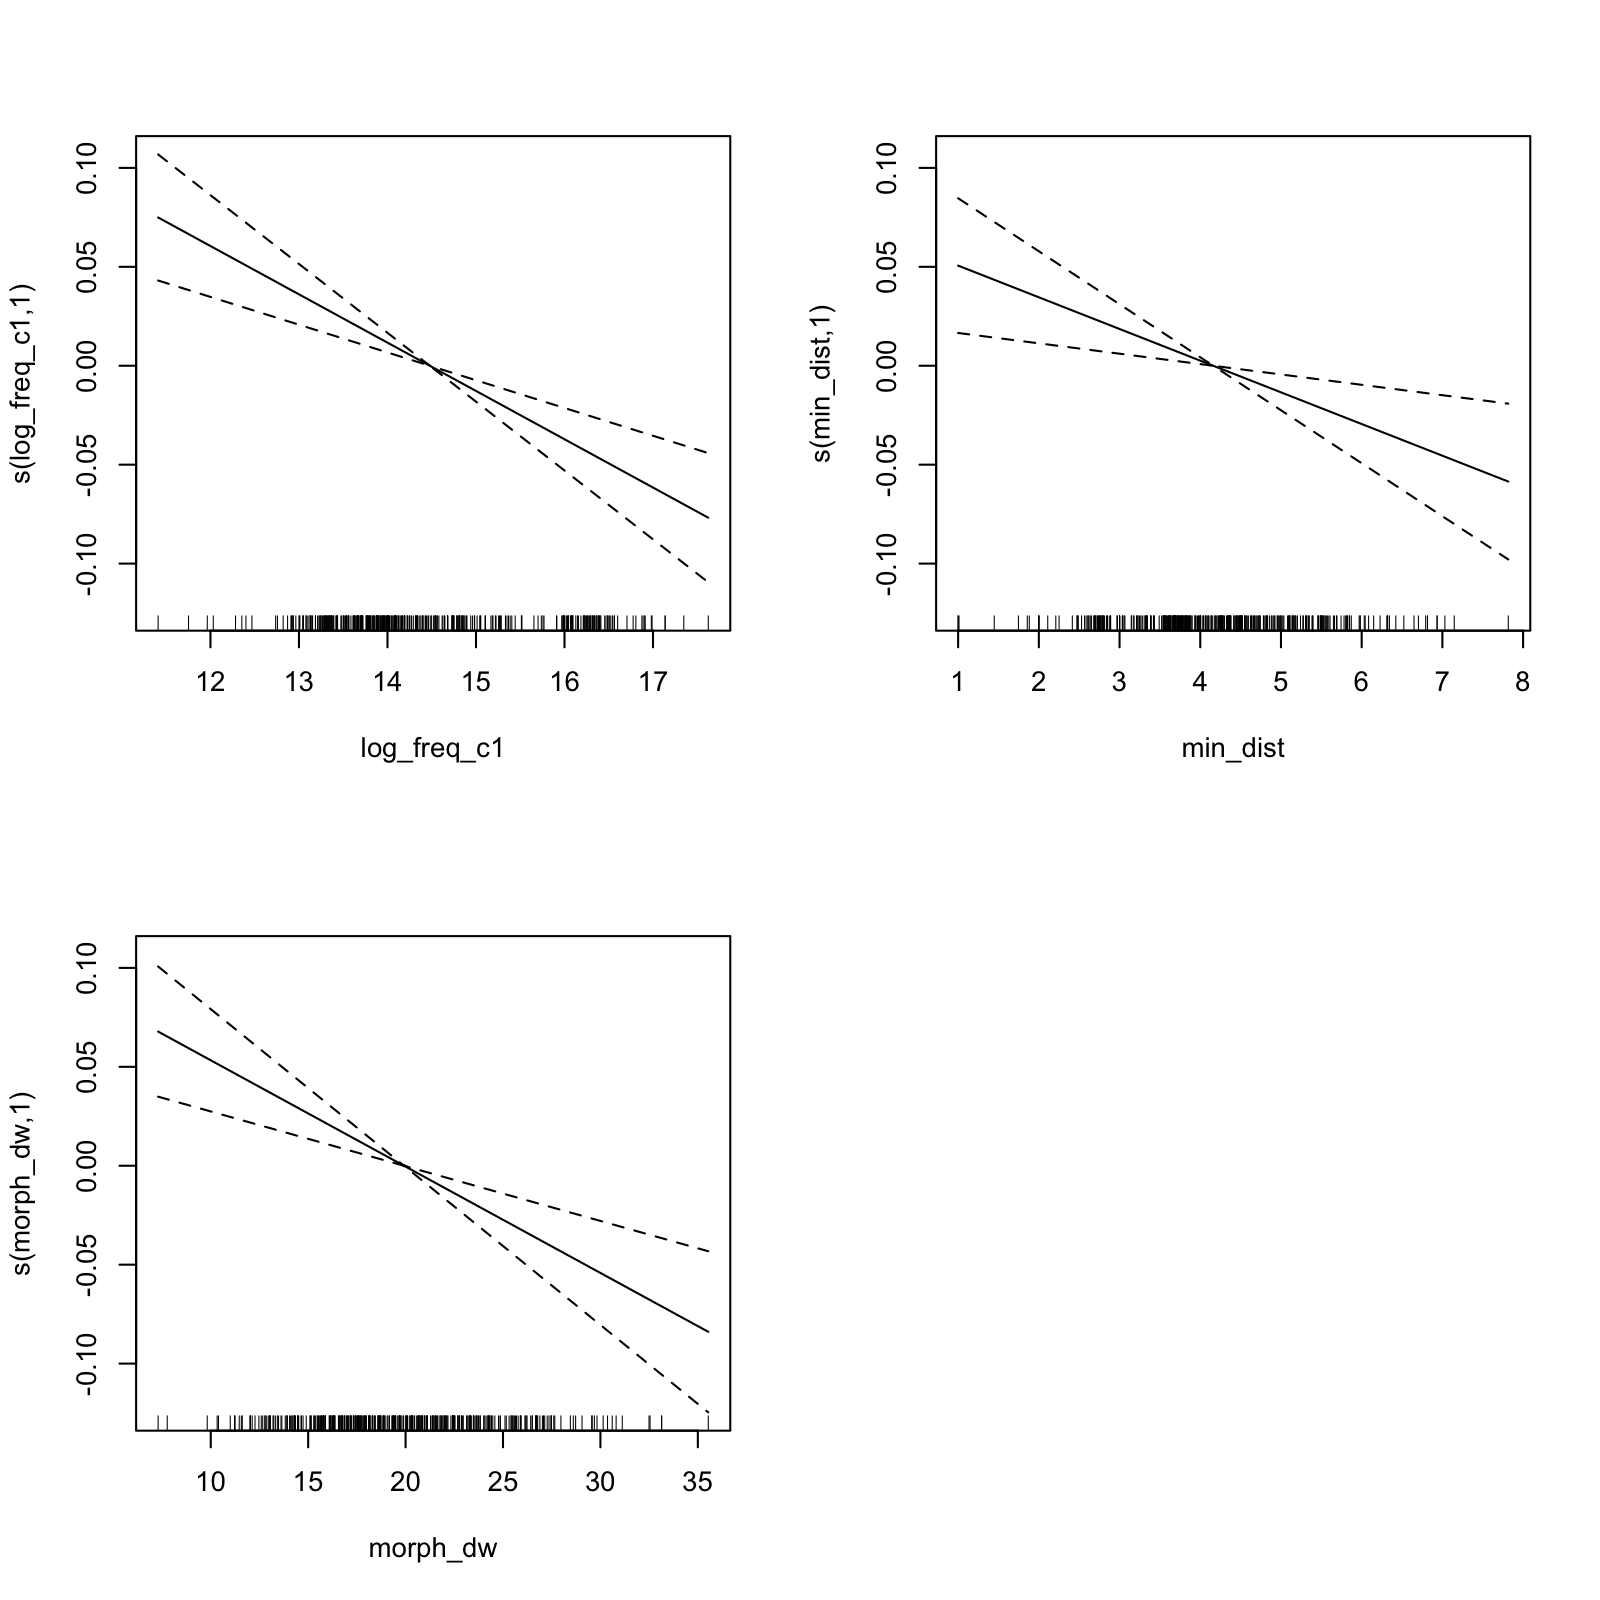

In [40]:
popt(8, 8)
plot(m5, pages=1)


Method: ML   Optimizer: outer newton
full convergence after 11 iterations.
Gradient range [-2.750079e-05,7.862016e-06]
(score -302.3832 & scale 0.01259681).
Hessian positive definite, eigenvalue range [2.428314e-05,195.5].
Model rank =  28 / 28 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

               k' edf k-index p-value
s(log_freq_c1)  9   1    1.07    0.90
s(min_dist)     9   1    1.02    0.64
s(morph_dw)     9   1    0.96    0.18


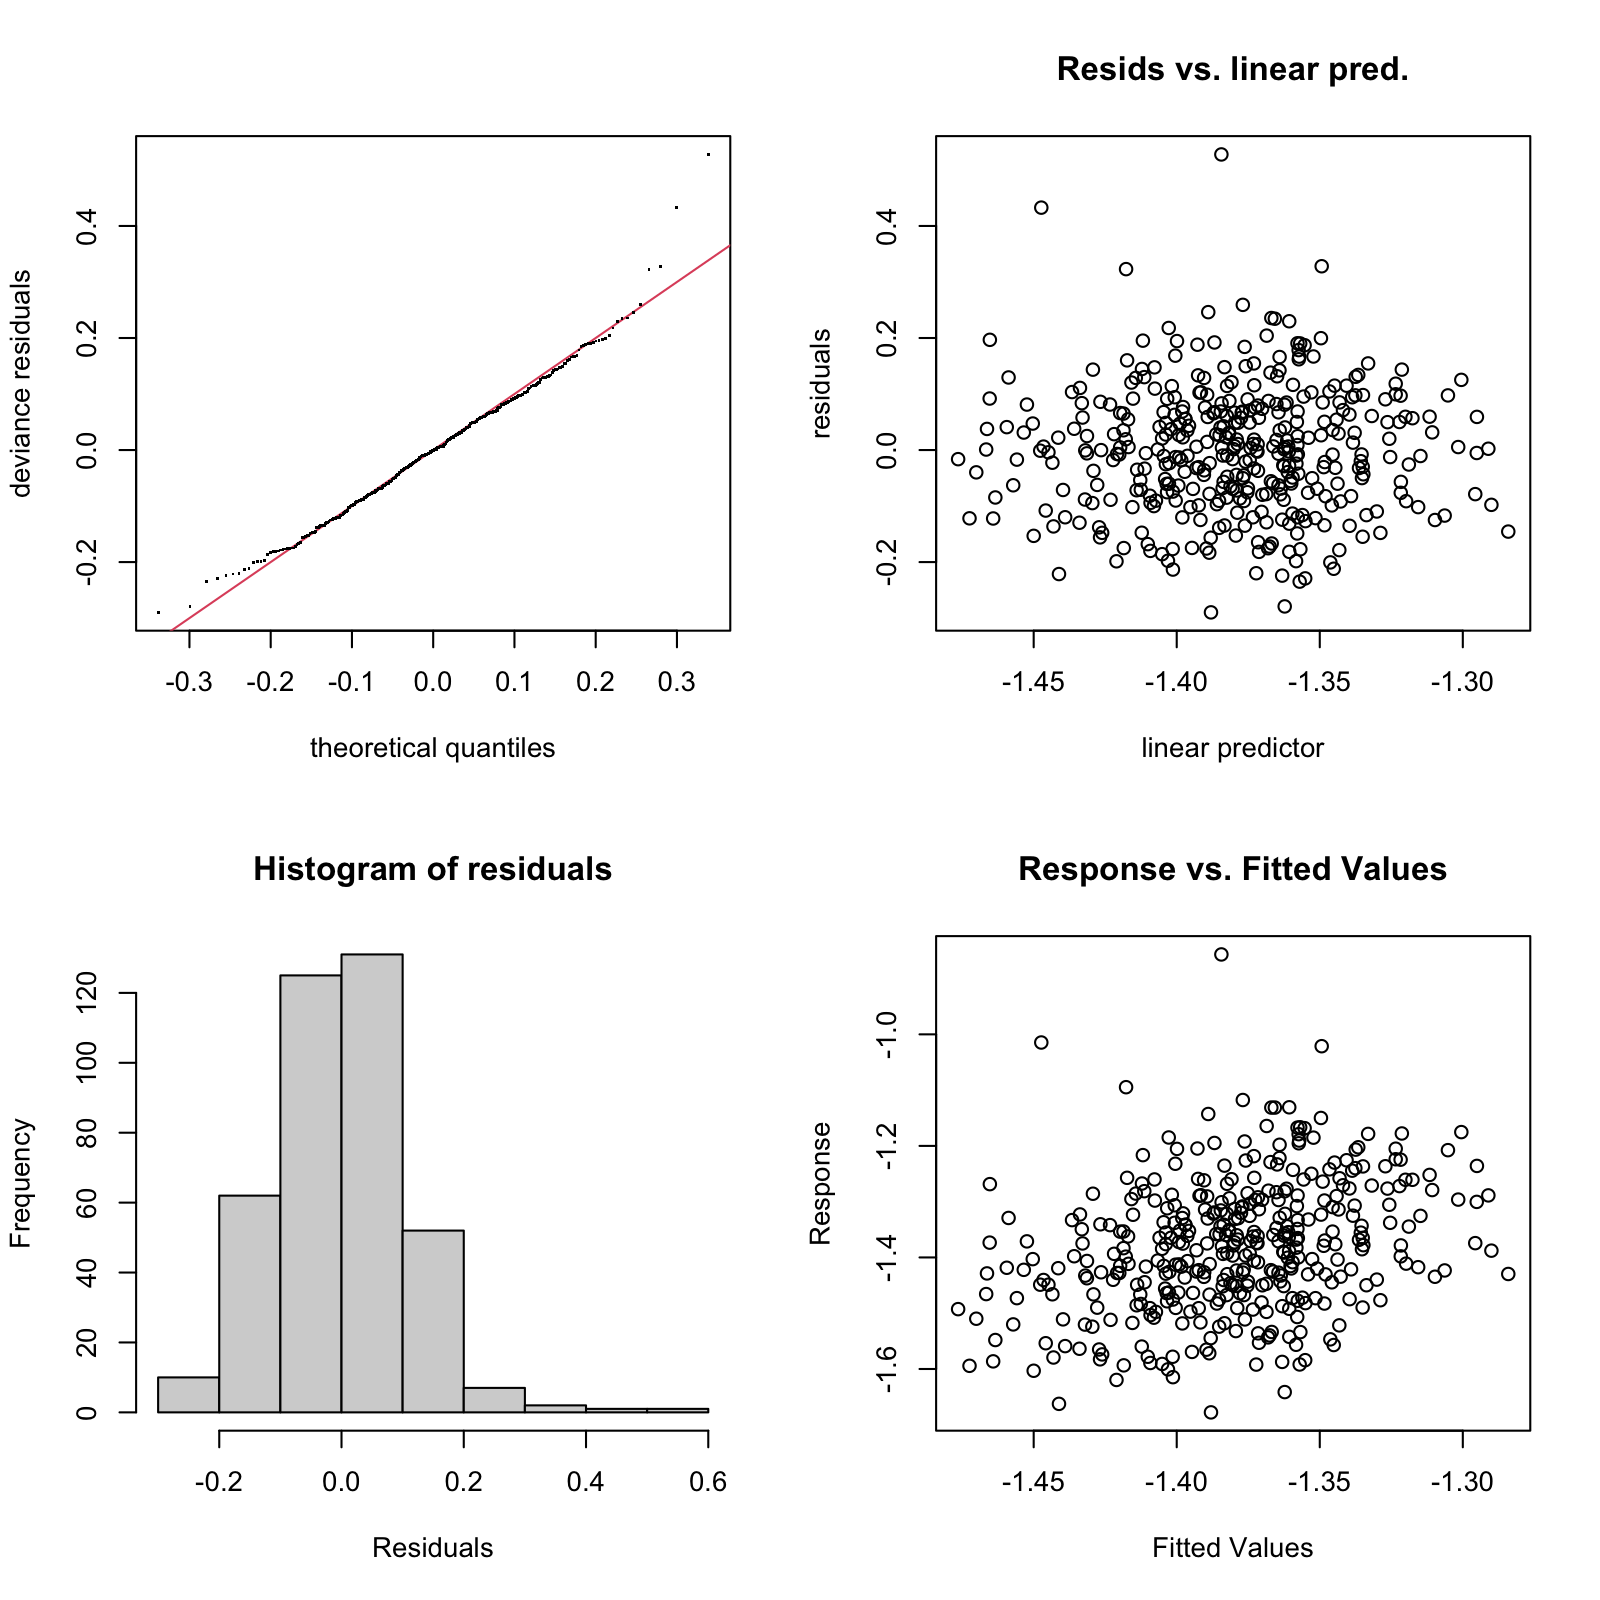

In [41]:
gam.check(m5)

## M5 with log_nsense

In [48]:
concurvity(m5)

,para,s(log_freq_c1),s(min_dist),s(morph_dw)
worst,5.698002e-24,0.1888026,0.1712612,0.2135488
observed,5.698002e-24,0.1722257,0.1586548,0.1783482
estimate,5.698002e-24,0.1411222,0.1244431,0.1351926


In [47]:
m6 = bam(RTinv~s(log_freq_c1)+s(min_dist)+s(morph_dw)+s(log_nsense_c1)+s(log_nsense_c2), data=nwdata, method="ML")
summary(m6)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(min_dist) + s(morph_dw) + s(log_nsense_c1) + 
    s(log_nsense_c2)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.380301   0.005668  -243.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df      F  p-value    
s(log_freq_c1)     1      1 17.937 2.91e-05 ***
s(min_dist)        1      1  9.455  0.00226 ** 
s(morph_dw)        1      1 18.223 2.52e-05 ***
s(log_nsense_c1)   1      1  0.001  0.98221    
s(log_nsense_c2)   1      1  2.868  0.09113 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0931   Deviance explained = 10.5%
-ML = -303.92  Scale est. = 0.012563  n = 391

## Diving into M4: morph_dw & c1_wD

In [141]:
summary(m4)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw) + s(c1_wD)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.37224    0.00218  -629.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df       F  p-value    
s(log_freq_c1) 1.000  1.000  81.773  < 2e-16 ***
s(log_freq_c2) 1.000  1.000  51.274  < 2e-16 ***
s(morph_dw)    1.000  1.000 150.919  < 2e-16 ***
s(c1_wD)       2.907  3.584   7.677 1.65e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0796   Deviance explained = 8.18%
fREML =  -1967  Scale est. = 0.011842  n = 2493

In [137]:
m4.1 = bam(RTinv~te(log_freq_c1, log_freq_c2)+s(morph_dw)+s(c1_wD), data=nwdata)
summary(m4.1)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ te(log_freq_c1, log_freq_c2) + s(morph_dw) + s(c1_wD)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002179  -629.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                              edf Ref.df       F  p-value    
te(log_freq_c1,log_freq_c2) 3.000  3.000  39.675  < 2e-16 ***
s(morph_dw)                 1.000  1.000 151.023  < 2e-16 ***
s(c1_wD)                    2.904  3.581   7.644 1.75e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0797   Deviance explained = 8.23%
fREML = -1970.9  Scale est. = 0.011841  n = 2493

In [138]:
m4.2 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+te(morph_dw, c1_wD), data=nwdata)
summary(m4.2)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + te(morph_dw, c1_wD)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002179  -629.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                     edf Ref.df     F p-value    
s(log_freq_c1)     1.105  1.204 70.24  <2e-16 ***
s(log_freq_c2)     1.000  1.000 51.96  <2e-16 ***
te(morph_dw,c1_wD) 6.201  7.907 25.88  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0798   Deviance explained = 8.29%
fREML = -1970.1  Scale est. = 0.01184   n = 2493

## M3: morph_dw and min_dist x c1_wD

In [152]:
m3.1 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+s(morph_dw)+te(min_dist, c1_wD), data=nwdata)
summary(m3.1)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw) + te(min_dist, 
    c1_wD)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002177  -630.4   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                     edf Ref.df       F  p-value    
s(log_freq_c1)     1.000  1.000  84.416  < 2e-16 ***
s(log_freq_c2)     1.000  1.000  54.289  < 2e-16 ***
s(morph_dw)        1.000  1.000 143.248  < 2e-16 ***
te(min_dist,c1_wD) 4.902  5.693   6.303 3.33e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0819   Deviance explained = 8.48%
fREML = -1968.9  Scale est. = 0.011814  n = 2493

In [153]:
AIC(m4, m4.1, m4.2, m3.1)

,df,AIC
,<dbl>,<dbl>
m4,8.114776,-3974.972
m4.1,9.108635,-3974.197
m4.2,12.110215,-3969.870
m3.1,10.294882,-3978.621


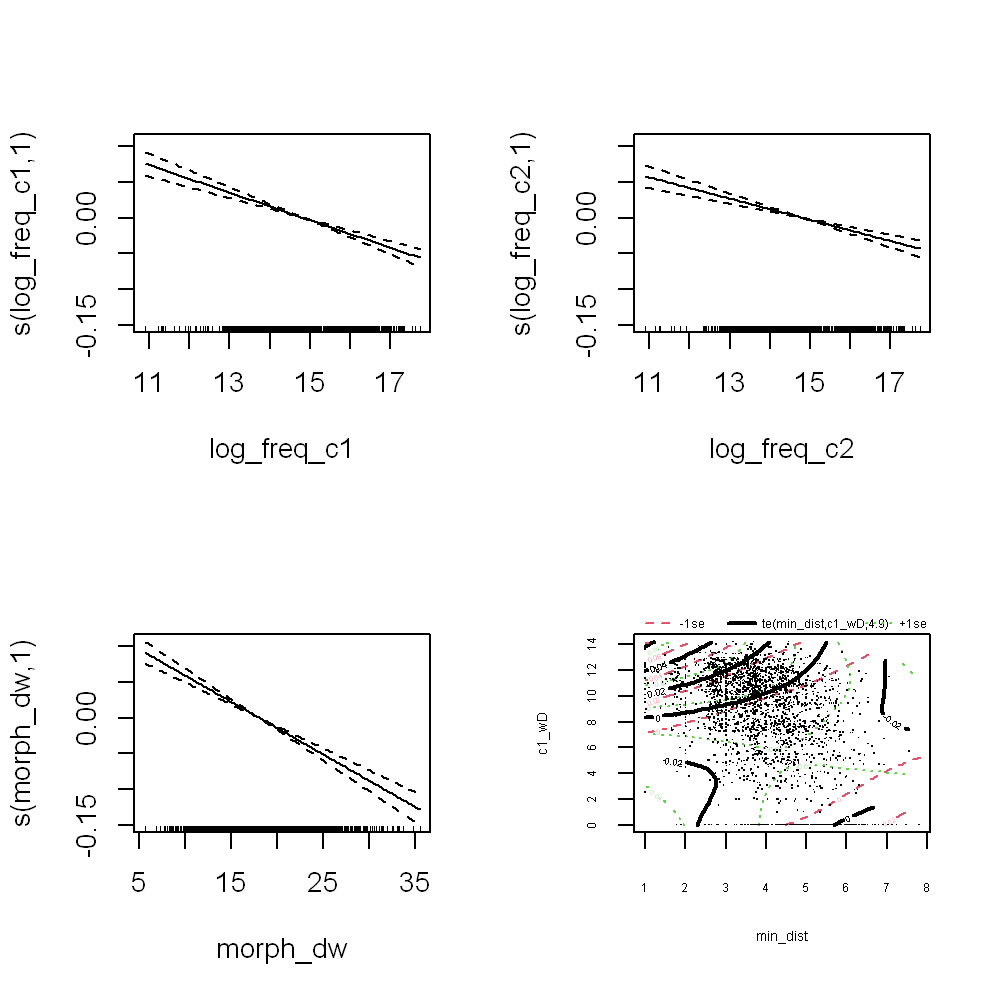

In [165]:
popt(5, 5)
plot(m3.1, pages=1)

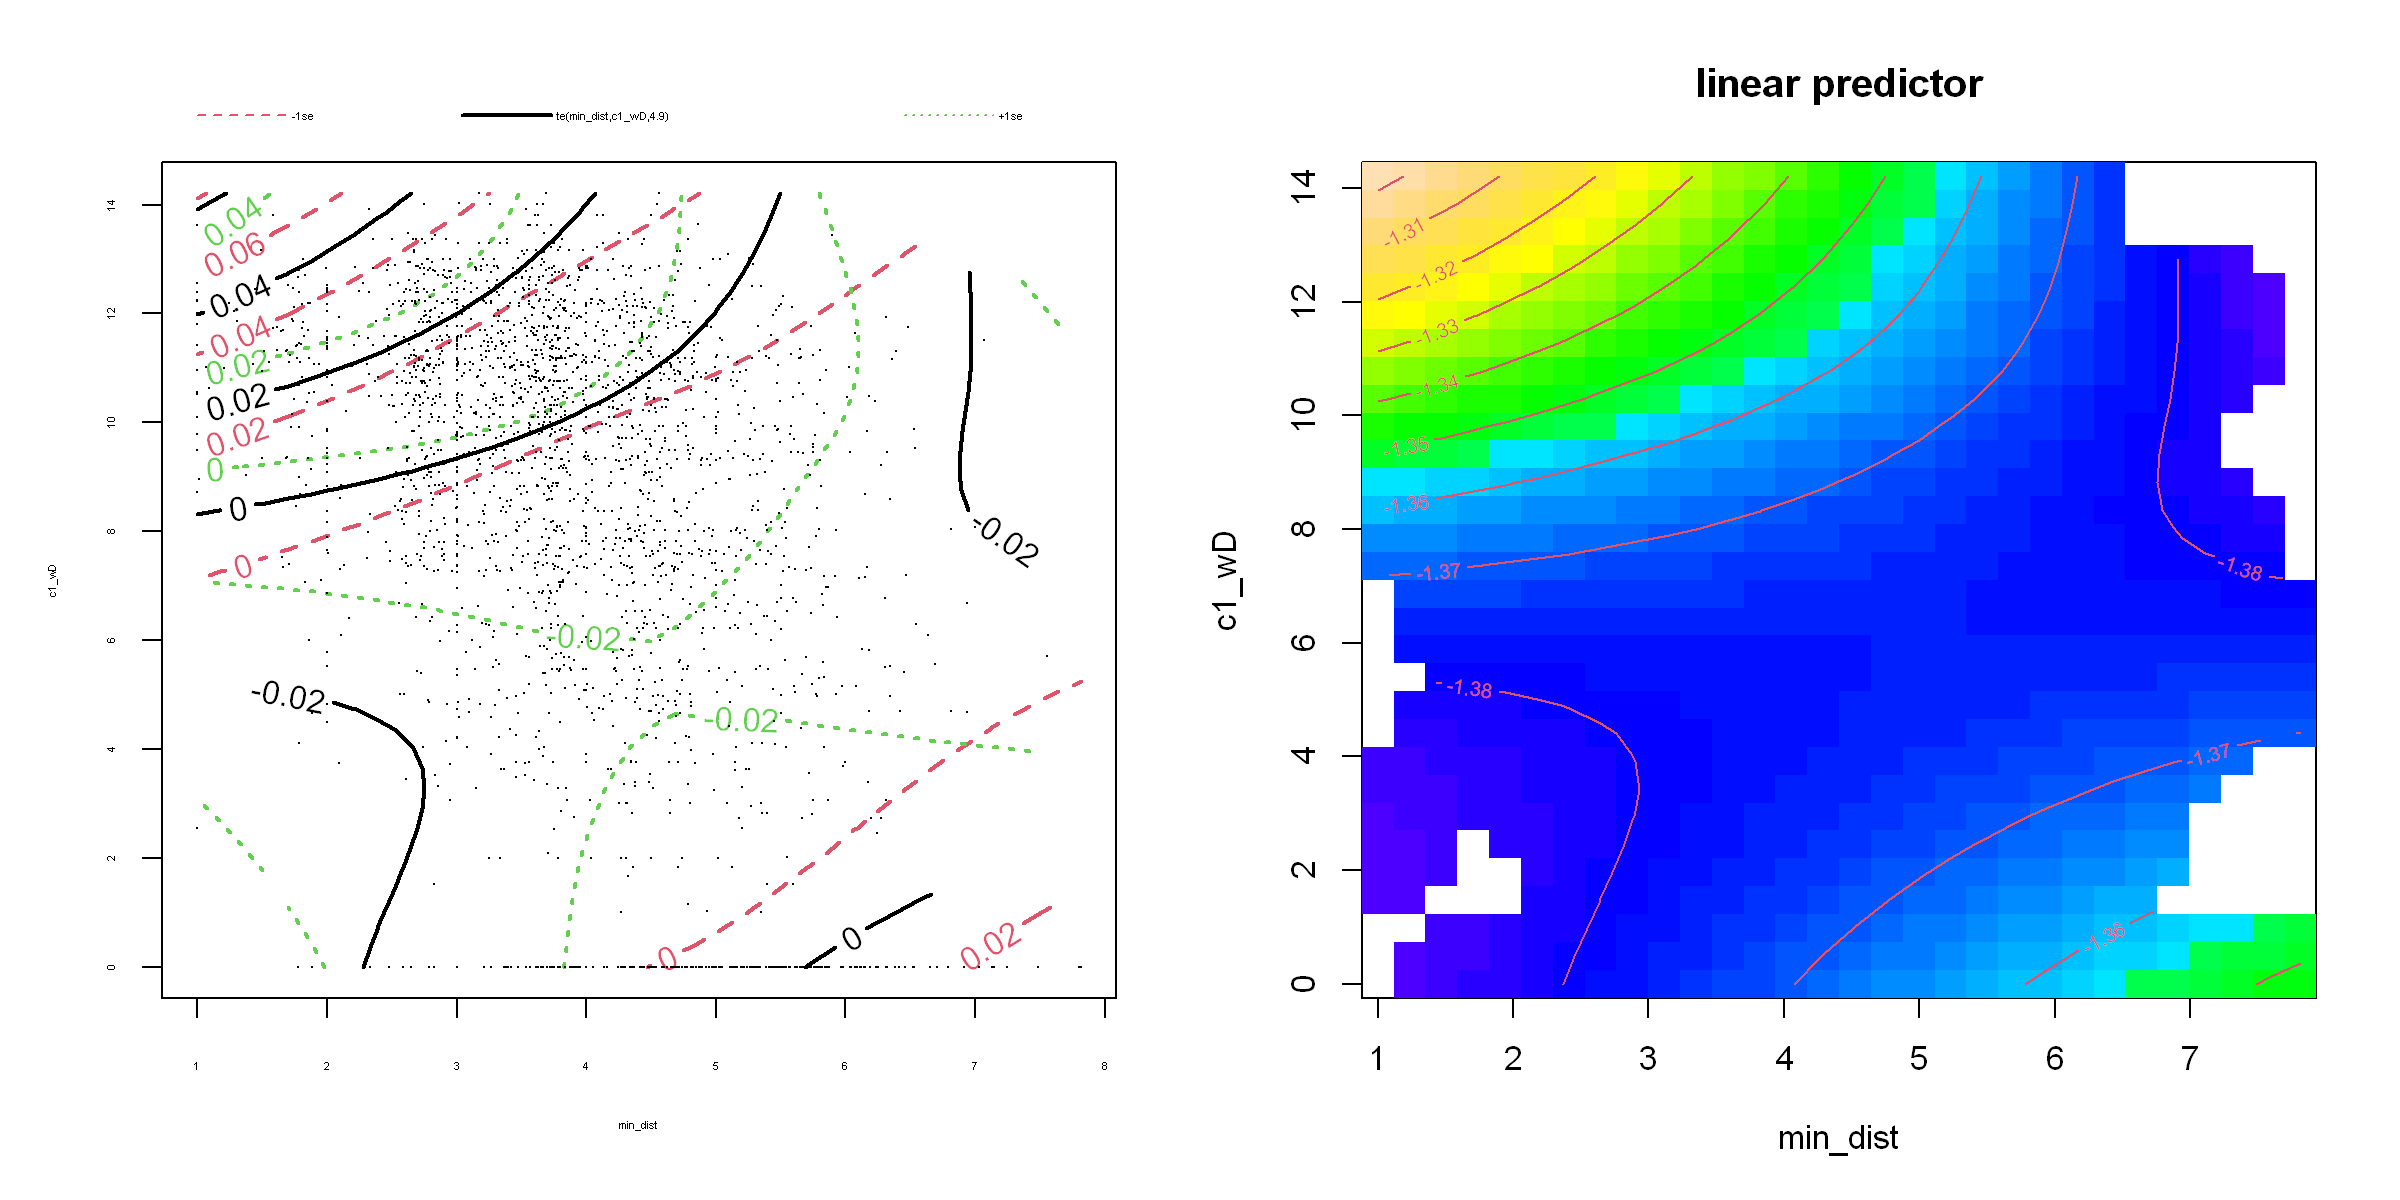

In [166]:
plot_int(m3.1, 4, "min_dist", "c1_wD")

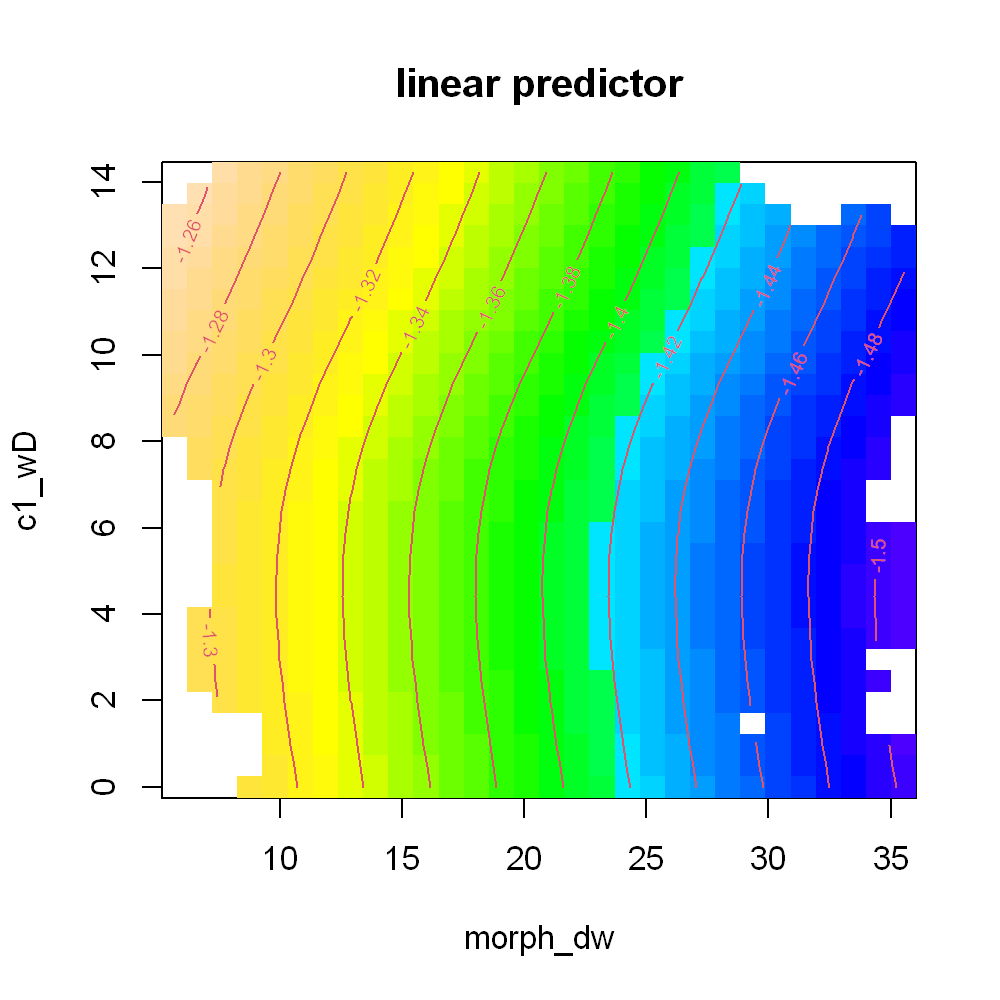

In [168]:
popt(5, 5)
vis.gam(m3.1, c("morph_dw", "c1_wD"), plot.type="contour", color="topo", too.far=0.1)

## Is Acc relevant??

In [15]:
require(MASS)

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




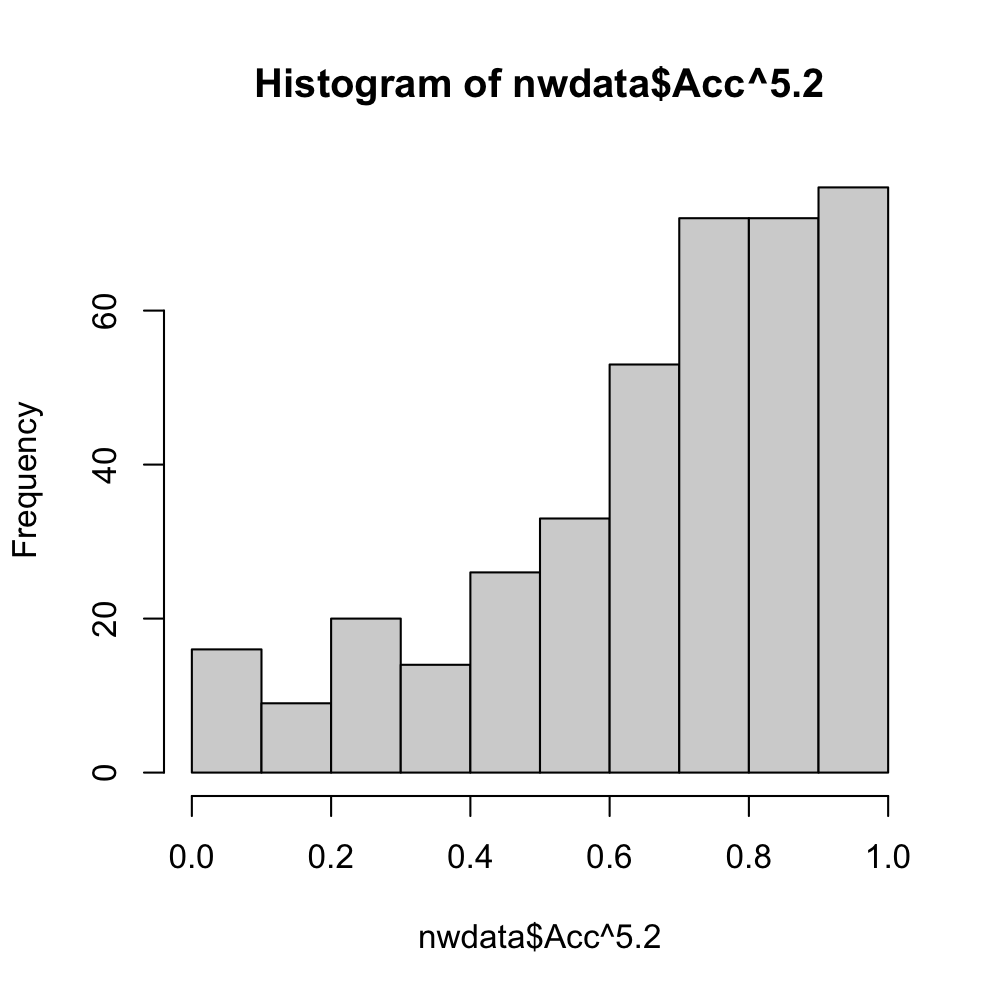

In [26]:
popt(5, 5)
hist(nwdata$Acc**5.2)

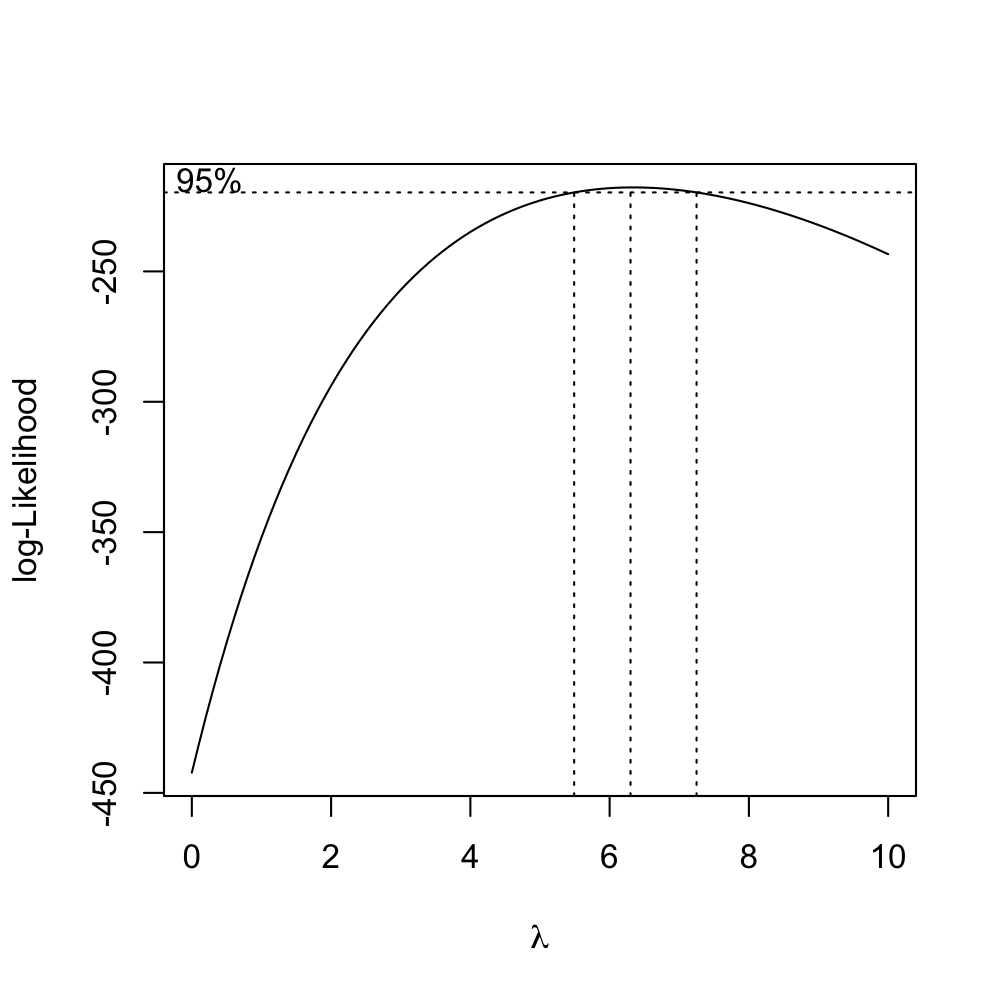

In [22]:
popt(5, 5)
boxcox(lm(Acc~1, data=nwdata), lambda=seq(0,10,0.1))

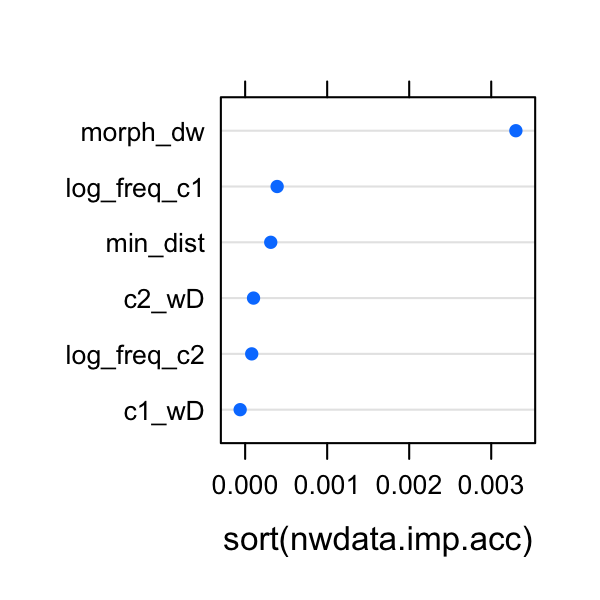

In [7]:
popt(3, 3, 200)
nwdata.cf.acc = cforest(Acc~., data=nwdata[,
                    c("Acc", "log_freq_c1", "log_freq_c2", "min_dist", "morph_dw", "c1_wD", "c2_wD")])
nwdata.imp.acc = varimp(nwdata.cf.acc)
dotplot(sort(nwdata.imp.acc), main=list(cex=2))

In [8]:
ma2 = bam(Acc~s(log_freq_c1)+s(log_freq_c2)+s(min_dist)+s(morph_dw), data=nwdata)
summary(ma2)


Family: gaussian 
Link function: identity 

Formula:
Acc ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.905550   0.005251   172.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df      F  p-value    
s(log_freq_c1) 1.000  1.000 11.811 0.000653 ***
s(log_freq_c2) 1.000  1.000  0.006 0.937870    
s(min_dist)    1.000  1.000  5.772 0.016761 *  
s(morph_dw)    2.518  3.221 12.390  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.135   Deviance explained = 14.8%
fREML = -310.62  Scale est. = 0.010782  n = 391

In [29]:
nwdata$Acc_tr = nwdata$Acc ** 6
ma2.tr = bam(Acc_tr**6~s(log_freq_c1)+s(log_freq_c2)+s(min_dist)+s(morph_dw), data=nwdata)
summary(ma2.tr)


Family: gaussian 
Link function: identity 

Formula:
Acc_tr^6 ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.28135    0.01808   15.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df      F  p-value    
s(log_freq_c1) 1.000  1.000  9.349  0.00239 ** 
s(log_freq_c2) 1.000  1.000  0.016  0.90050    
s(min_dist)    1.858  2.377  2.754  0.06498 .  
s(morph_dw)    1.032  1.063 17.562 2.97e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0764   Deviance explained =  8.8%
fREML = 166.01  Scale est. = 0.12784   n = 391


Method: fREML   Optimizer: perf newton
full convergence after 15 iterations.
Gradient range [-1.024184e-06,9.364144e-07]
(score 166.0092 & scale 0.1278352).
Hessian positive definite, eigenvalue range [4.103319e-07,193.001].
Model rank =  37 / 37 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                 k'  edf k-index p-value
s(log_freq_c1) 9.00 1.00    0.98    0.36
s(log_freq_c2) 9.00 1.00    0.99    0.42
s(min_dist)    9.00 1.86    1.07    0.94
s(morph_dw)    9.00 1.03    1.00    0.48


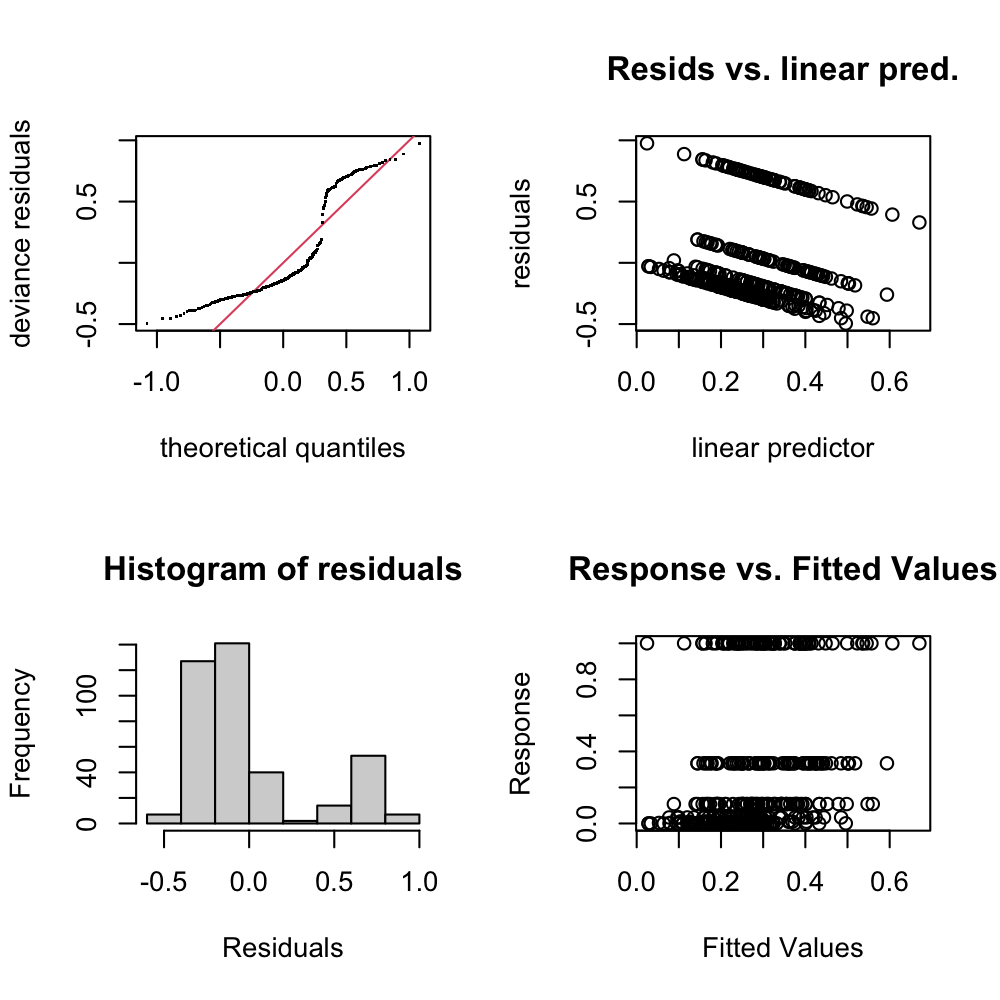

In [30]:
gam.check(ma2.tr)

In [9]:
ma2.1 = bam(Acc~s(log_freq_c1)+s(log_freq_c2)+te(min_dist, morph_dw), data=nwdata)
summary(ma2.1)


Family: gaussian 
Link function: identity 

Formula:
Acc ~ s(log_freq_c1) + s(log_freq_c2) + te(min_dist, morph_dw)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.905550   0.005258   172.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                        edf Ref.df      F p-value    
s(log_freq_c1)        1.000  1.000 10.952 0.00102 ** 
s(log_freq_c2)        1.000  1.000  0.012 0.91127    
te(min_dist,morph_dw) 4.289  5.066 10.850 < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.133   Deviance explained = 14.7%
fREML = -315.26  Scale est. = 0.010811  n = 391

In [10]:
ma3 = bam(Acc~s(log_freq_c1)+s(log_freq_c2)+s(min_dist)+s(morph_dw)+s(c1_wD), data=nwdata)
summary(ma3)


Family: gaussian 
Link function: identity 

Formula:
Acc ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw) + 
    s(c1_wD)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.905550   0.005254   172.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df      F p-value    
s(log_freq_c1) 1.000  1.000  9.475 0.00223 ** 
s(log_freq_c2) 1.000  1.000  0.000 0.98424    
s(min_dist)    1.000  1.000  6.228 0.01300 *  
s(morph_dw)    2.495  3.192 12.510 < 2e-16 ***
s(c1_wD)       1.131  1.248  0.475 0.61373    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.134   Deviance explained = 14.9%
fREML = -306.7  Scale est. = 0.010795  n = 391

In [11]:
ma3.1 = bam(Acc~s(log_freq_c1)+s(log_freq_c2)+s(morph_dw)+te(min_dist, c1_wD), data=nwdata)
summary(ma3.1)


Family: gaussian 
Link function: identity 

Formula:
Acc ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw) + te(min_dist, 
    c1_wD)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.905550   0.005256   172.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                     edf Ref.df      F p-value    
s(log_freq_c1)     1.000   1.00  9.957 0.00173 ** 
s(log_freq_c2)     1.000   1.00  0.000 0.99464    
s(morph_dw)        2.354   3.02 13.075 < 2e-16 ***
te(min_dist,c1_wD) 3.000   3.00  2.500 0.05919 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.134   Deviance explained =   15%
fREML = -310.58  Scale est. = 0.010801  n = 391

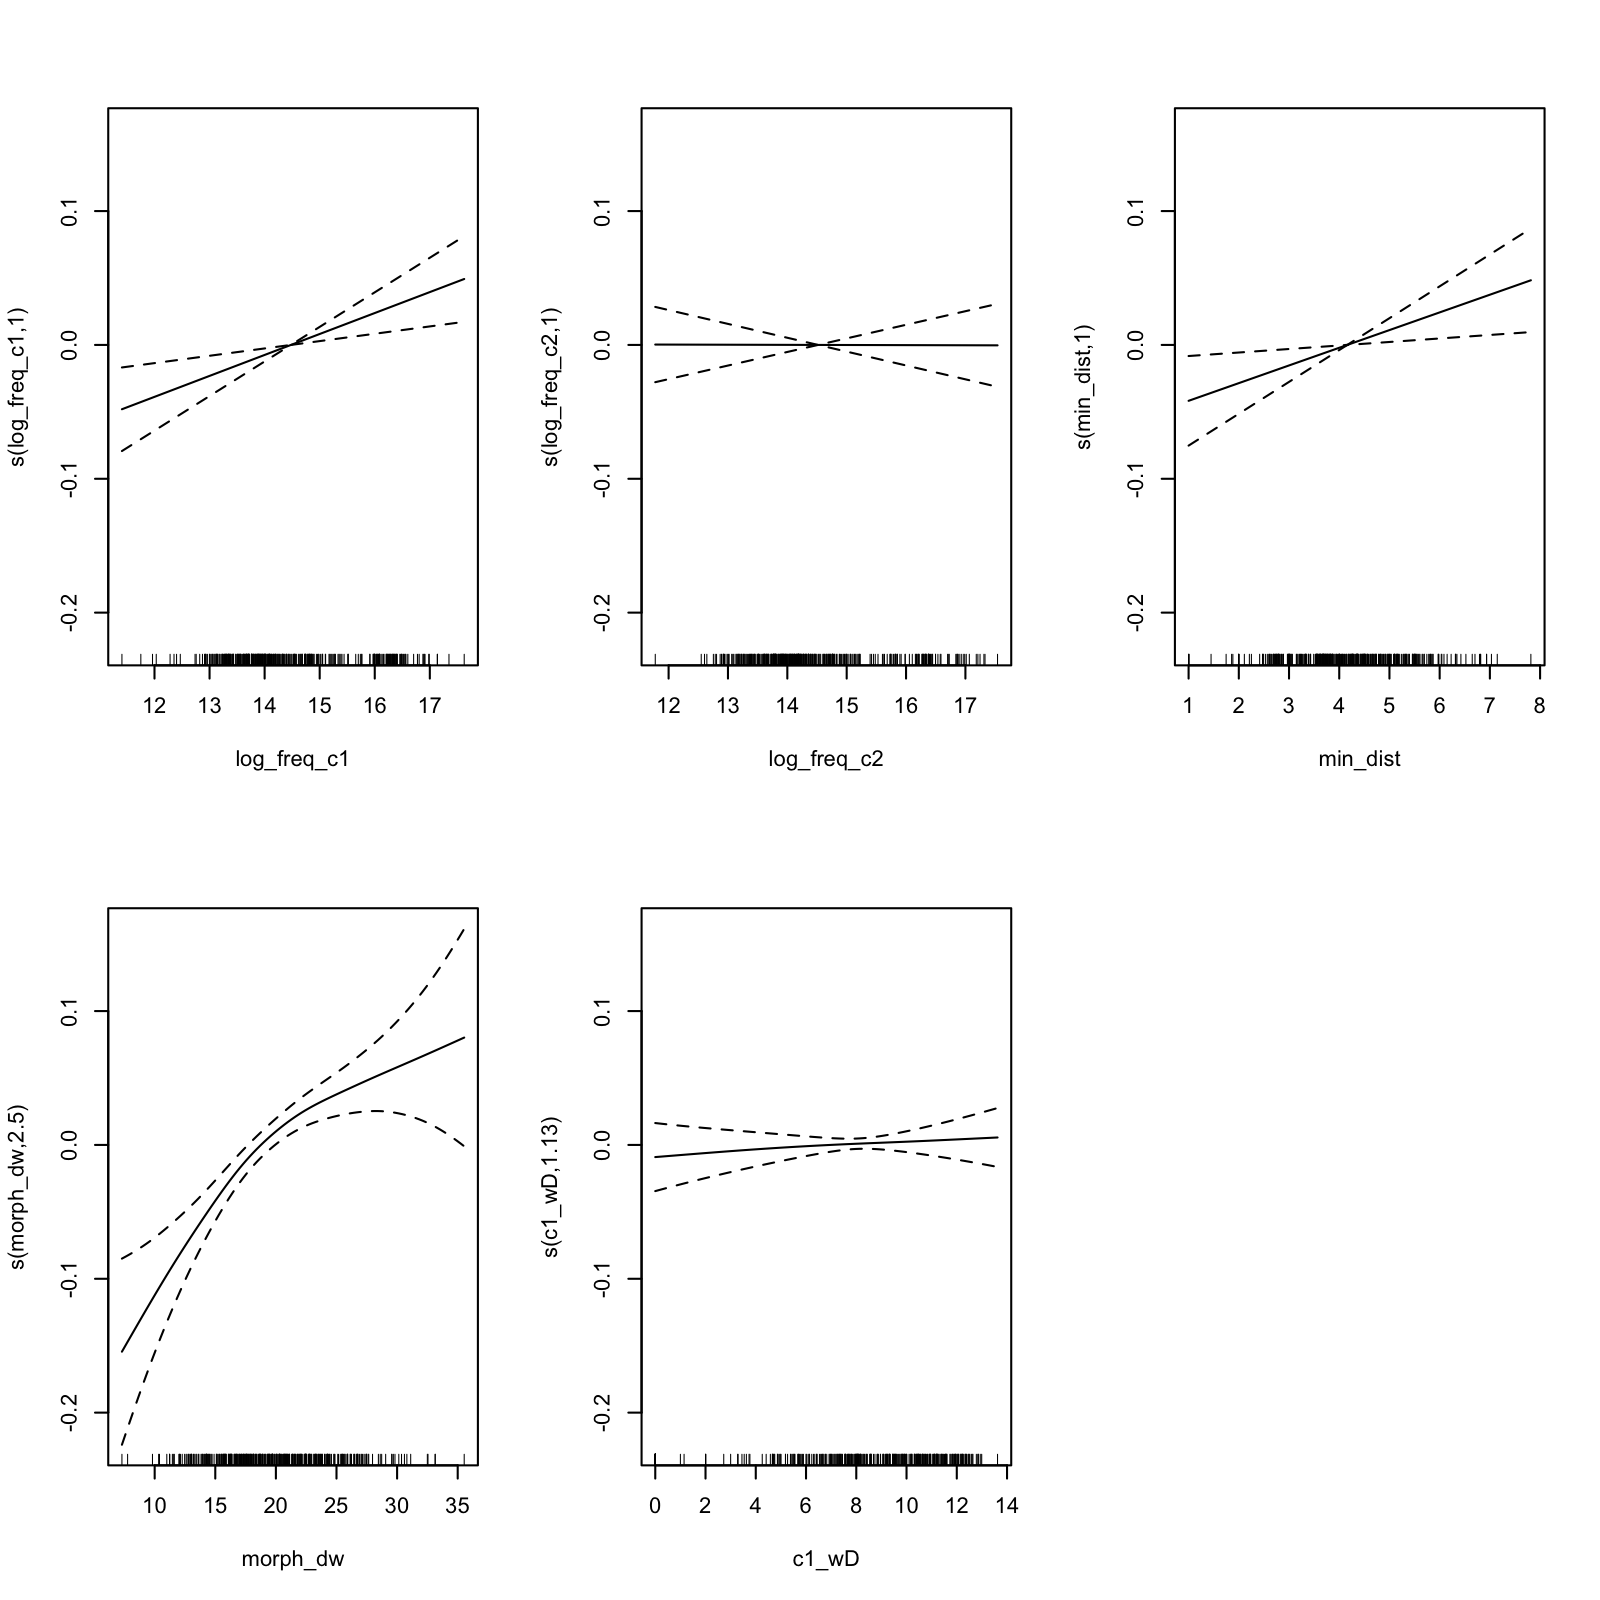

In [13]:
popt(8, 8)
plot(ma3, pages=1)

In [161]:
AIC(ma2, ma2.1, ma3, ma3.1)

,df,AIC
,<dbl>,<dbl>
ma2,8.768733,-3917.027
ma2.1,12.844184,-3920.440
ma3,11.403188,-3918.749
ma3.1,11.093524,-3919.338


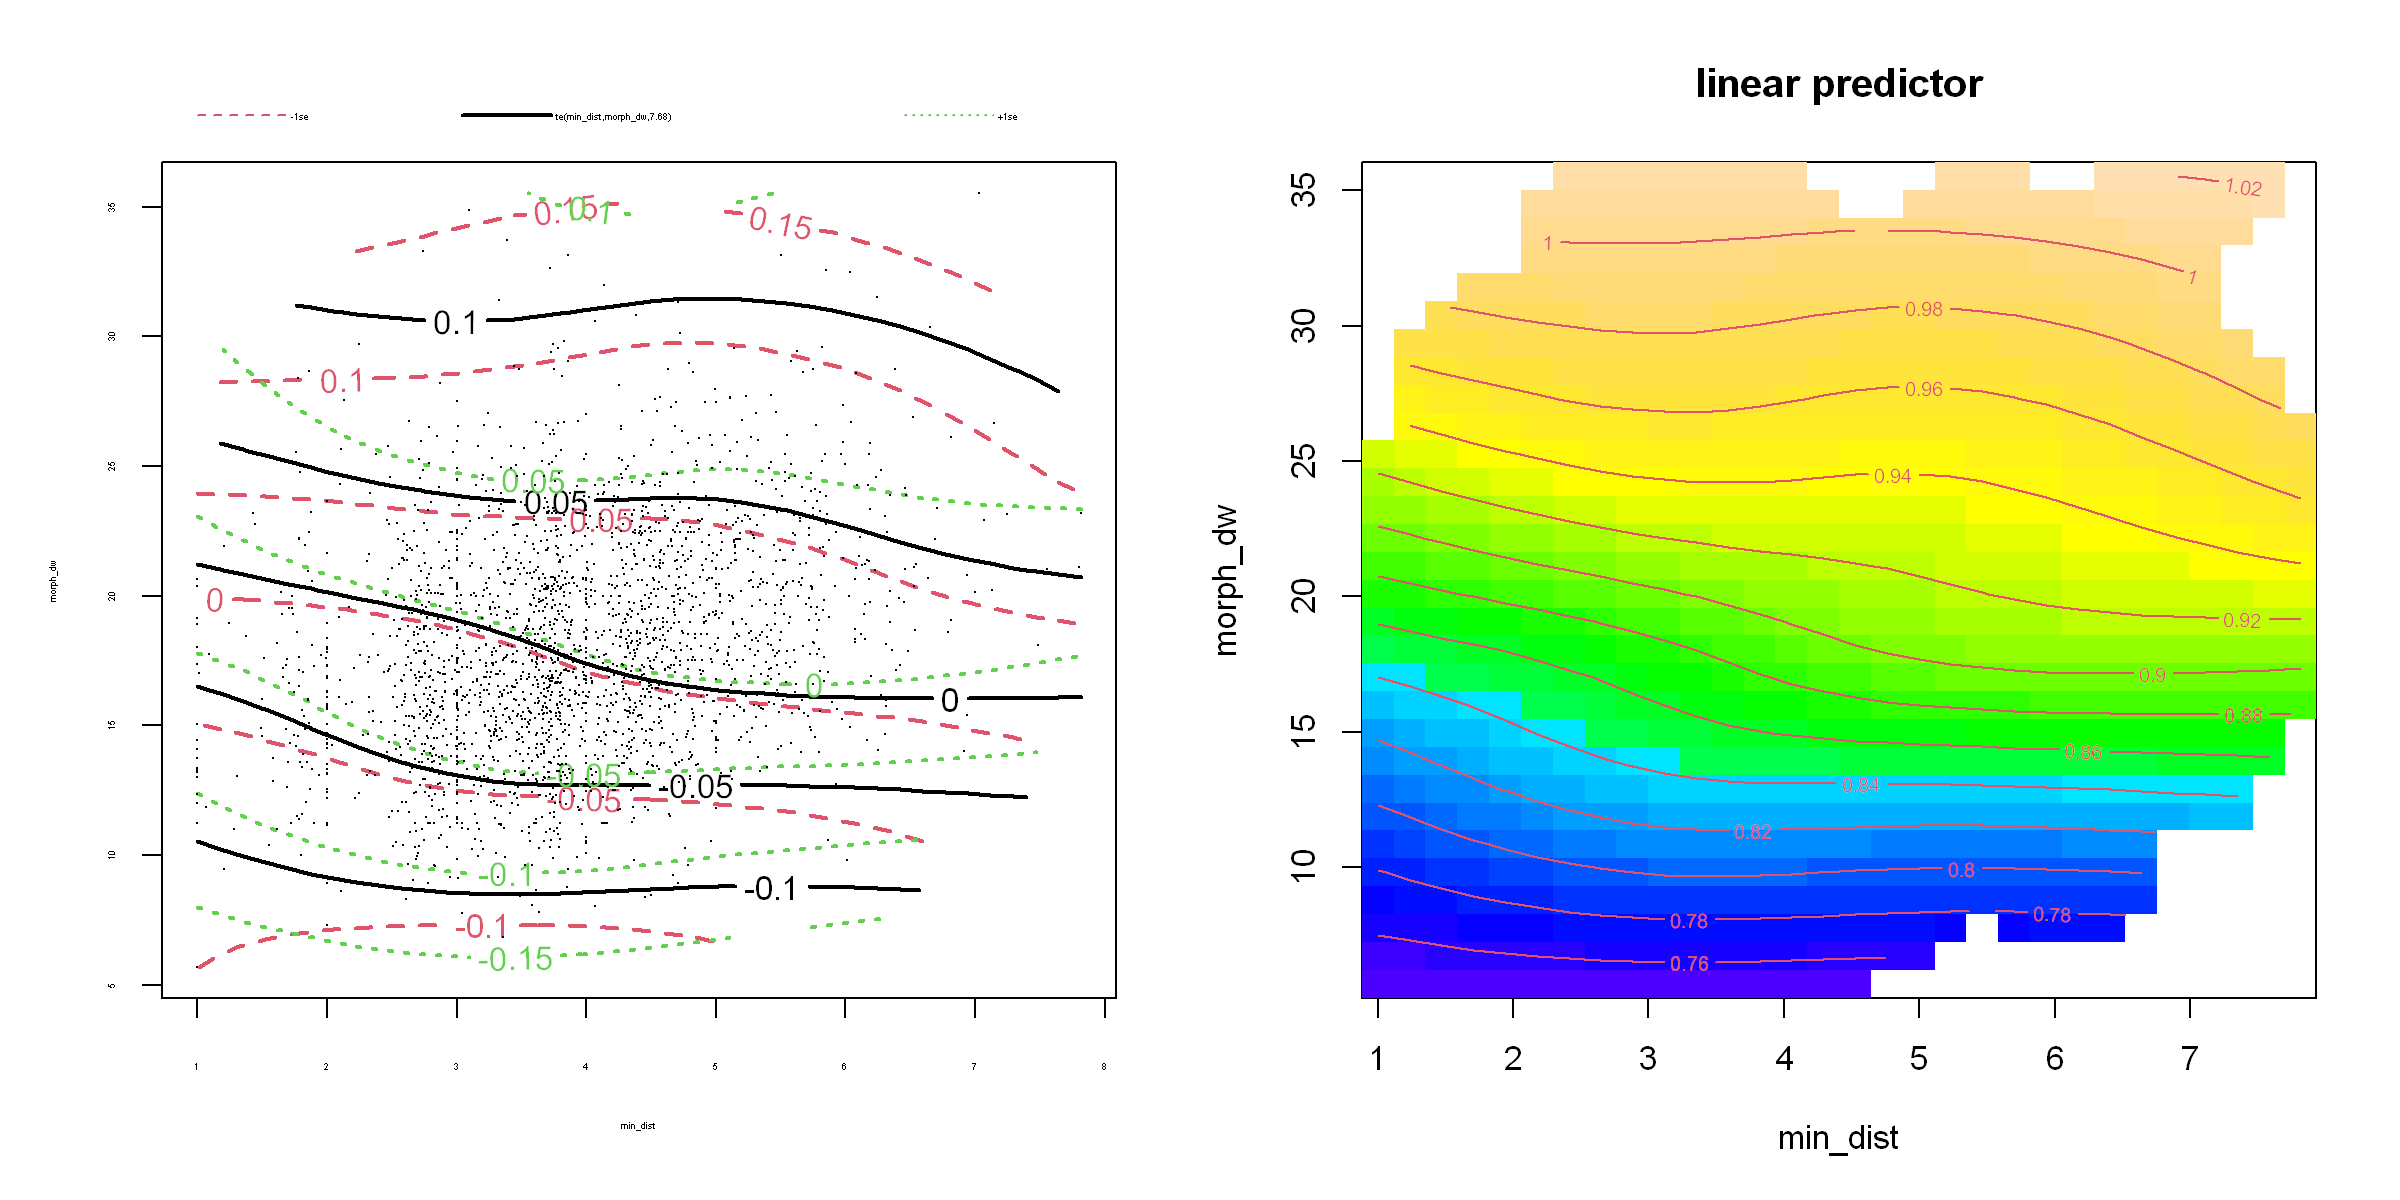

In [162]:
plot_int(ma2.1, 3, "min_dist", "morph_dw")